In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1993217540940559742
xla_global_id: -1
]


In [ ]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [ ]:
#This part linkes the dataset in the drive to the google colab file
#oldlink = 'https://drive.google.com/file/d/1TxMpCYlXbuakmrVVacn6IRT6kOVEP-Cf/view?usp=sharing'
link = 'https://drive.google.com/file/d/1TH1vQRhqoRNfuKZgVsMVnfkrjS60ChXL/view?usp=sharing'
id = link.split('/')[-2]
downloaded = drive.CreateFile({'id' : id})
downloaded.GetContentFile('StockPrices.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('StockPrices.csv')
df["DailyRet"] = 0
df["20DayRet"] = 0
df["20DayVol"] = 0
df["Z20DayRet"] = 0
df['Z20DayVol'] = 0
df['Date']= pd.to_datetime(df['Date'])
df_close = df[['Date', 'Index', 'Close']] 
df_close.info()
df_close = df_close.pivot_table(index = 'Date', columns = 'Index', values = 'Close').dropna(axis=1)
stocks_tickers = df_close.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199746 entries, 0 to 199745
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    199746 non-null  datetime64[ns]
 1   Index   199746 non-null  object        
 2   Close   199422 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.6+ MB


In [ ]:
#Saving Trading Days
dates = df_close.index 

#Saving Stocks
stocks = df_close.columns

In [ ]:
df.columns

Index(['Date', 'Index', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted',
       'DailyRet', '20DayRet', '20DayVol', 'Z20DayRet', 'Z20DayVol'],
      dtype='object')

In [ ]:
raw_df = df.set_index(['Date' , 'Index']).unstack(level = 1).stack(level = 0).unstack()
#raw_df = raw_df.dropna(axis = 1)
for stock in stocks_tickers:
  #Calculate Daily Returns
  raw_df.loc[:, (stock, 'DailyRet')] = raw_df[stock]["Close"].pct_change()
  #Calculate 20-Day Returns
  raw_df.loc[:, (stock, '20DayRet')] = raw_df[stock]["Close"].pct_change(20)
  #Calculate Rolling 20 day volatility 
  roller = raw_df[stock]["DailyRet"].rolling(20)
  raw_df.loc[:, (stock, '20DayVol')] = roller.std(ddof=0)
  
  '''Normalize data with the rolling 252'''
  #Normalize 20 Day Returns 
  rolling_year_ret = raw_df[stock]["20DayRet"].rolling(252)
  raw_df.loc[:, (stock, 'Z20DayRet')] = (rolling_year_ret.mean().shift(1) - raw_df[stock]['20DayRet']) / rolling_year_ret.std(ddof=0).shift(1)
  #Normalize 20 Day Volatility
  rolling_year_vol = raw_df[stock]["20DayVol"].rolling(252)
  raw_df.loc[:, (stock, 'Z20DayVol')] = (rolling_year_vol.mean().shift(1) - raw_df[stock]['20DayVol']) / rolling_year_vol.std(ddof=0).shift(1) 

raw_df.head(5)  

Index        ACC.NS                                                            \
           20DayRet 20DayVol     Adjusted        Close  DailyRet         High   
Date                                                                            
2012-08-16      NaN      NaN  1118.372803  1338.449951       NaN  1358.050049   
2012-08-17      NaN      NaN  1108.262207  1326.349976 -0.009040  1338.449951   
2012-08-21      NaN      NaN  1134.583008  1357.849976  0.023749  1363.000000   
2012-08-22      NaN      NaN  1137.256836  1361.050049  0.002357  1370.800049   
2012-08-23      NaN      NaN  1125.308228  1346.750000 -0.010507  1367.900024   

Index                                                     ... ZYDUSLIFE.NS  \
                    Low         Open    Volume Z20DayRet  ...     20DayVol   
Date                                                      ...                
2012-08-16  1335.099976  1356.000000  124774.0       NaN  ...          NaN   
2012-08-17  1320.150024  1335.150024  190538.0       NaN  ...          NaN   
2012-08-21  1320.000000  1330.000000  175534.0       NaN  ...          NaN   
2012-08-22  1345.199951  1351.500000  180195.0       NaN  ...          NaN   
2012-08-23  1340.000000  1366.000000  139318.0       NaN  ...          NaN   

Index                                                                 \
              Adjusted       Close  DailyRet        High         Low   
Date                                                                   
2012-08-16  153.041046  172.830002       NaN  173.940002  170.199997   
2012-08-17  155.095383  175.149994  0.013424  175.949997  173.000000   
2012-08-21  152.810791  172.570007 -0.014730  177.800003  170.199997   
2012-08-22  155.449600  175.550003  0.017268  177.970001  173.000000   
2012-08-23  154.245285  174.190002 -0.007747  177.539993  173.059998   

Index                                                 
                  Open    Volume Z20DayRet Z20DayVol  
Date                                                  
2012-08-16  173.809998  465130.0       NaN       NaN  
2012-08-17  173.000000   77795.0       NaN       NaN  
2012-08-21  175.399994  291750.0       NaN       NaN  
2012-08-22  173.000000  226630.0       NaN       NaN  
2012-08-23  176.000000  114420.0       NaN       NaN  

[5 rows x 891 columns]

In [ ]:
#DROP ROWS WITH NA vals 
full_feature_dataset = raw_df.dropna(axis=0)
#full_feature_dataset = raw_df

In [ ]:
raw_df.index

DatetimeIndex(['2012-08-16', '2012-08-17', '2012-08-21', '2012-08-22',
               '2012-08-23', '2012-08-24', '2012-08-27', '2012-08-28',
               '2012-08-29', '2012-08-30',
               ...
               '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-10',
               '2022-08-11', '2022-08-12'],
              dtype='datetime64[ns]', name='Date', length=2466, freq=None)

In [ ]:
full_features = raw_df[[]].columns.remove_unused_levels()

Principal Component Analysis

In [ ]:
full_feature_dataset.head()

Index         ACC.NS                                                        \
            20DayRet  20DayVol    Adjusted        Close  DailyRet     High   
Date                                                                         
2013-09-23  0.122714  0.024518  952.846985  1111.150024 -0.010772  1138.00   
2013-09-24  0.096307  0.024759  941.999268  1098.500000 -0.011385  1125.00   
2013-09-25  0.161487  0.020091  939.040649  1095.050049 -0.003141  1106.75   
2013-09-26  0.159416  0.020120  939.255127  1095.300049  0.000228  1117.75   
2013-09-27  0.147696  0.020078  942.899475  1099.550049  0.003880  1115.00   

Index                                                     ... ZYDUSLIFE.NS  \
                    Low         Open    Volume Z20DayRet  ...     20DayVol   
Date                                                      ...                
2013-09-23  1090.300049  1110.150024  390593.0 -2.061994  ...     0.008589   
2013-09-24  1086.150024  1100.150024  183976.0 -1.660285  ...     0.008368   
2013-09-25  1076.300049  1090.099976  261395.0 -2.581359  ...     0.008414   
2013-09-26  1082.349976  1090.000000  382724.0 -2.511170  ...     0.008176   
2013-09-27  1093.099976  1100.000000  173613.0 -2.309323  ...     0.008424   

Index                                                                 \
              Adjusted       Close  DailyRet        High         Low   
Date                                                                   
2013-09-23  122.460777  136.940002 -0.000365  138.759995  133.740005   
2013-09-24  122.577042  137.070007  0.000949  137.770004  135.399994   
2013-09-25  122.147797  136.589996 -0.003502  138.440002  135.339996   
2013-09-26  122.478668  136.960007  0.002709  137.570007  135.300003   
2013-09-27  123.954208  138.610001  0.012047  139.800003  135.929993   

Index                                                  
                  Open     Volume Z20DayRet Z20DayVol  
Date                                                   
2013-09-23  136.600006   270455.0 -0.884901  1.381906  
2013-09-24  136.419998  1447475.0 -1.015956  1.423397  
2013-09-25  138.440002    57360.0 -0.987478  1.401759  
2013-09-26  136.800003   148420.0 -1.137849  1.444183  
2013-09-27  137.699997   139545.0 -1.245373  1.374823  

[5 rows x 891 columns]

In [ ]:
full_feature_dataset = full_feature_dataset.to_numpy()
full_feature_dataset.shape

(2192, 891)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
closing_prices = df_close.iloc[:full_feature_dataset.shape[0],:]

In [ ]:
from sklearn.model_selection import train_test_split
#Division of data
# df_close = df_close.to_numpy()
array_train, array_test = train_test_split(closing_prices, shuffle = False, test_size = .2)
PCA_train, PCA_test = train_test_split(full_feature_dataset, shuffle = False, test_size = .2)

In [ ]:
print(PCA_train.shape)

(1753, 891)


In [ ]:
print(PCA_test.shape)

(439, 891)


In [ ]:
print(array_train.shape)
print(PCA_train.shape)

(1753, 81)
(1753, 891)


In [ ]:
from sklearn.decomposition import PCA
pc3 = PCA()
temp = pc3.fit_transform(PCA_train)

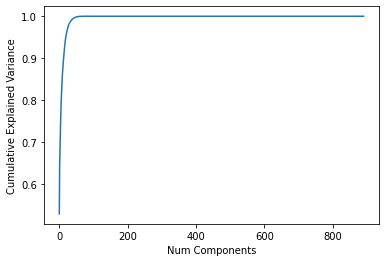

In [ ]:
plt.plot(np.cumsum(pc3.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance');

In [ ]:
#Data with only closing prices
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scale = MinMaxScaler()
array_train = scl.fit_transform(array_train)
array_test  = scale.fit_transform(array_test) #[0,1]

#Full features dataset; reducing dimensionality here
from sklearn.decomposition import PCA
pcTrain_scl = MinMaxScaler()
pcTest_scl  = MinMaxScaler()
pcaTrain = PCA(n_components = 81)
pcaTest = PCA(n_components = 81)

PCA_train = pcTrain_scl.fit_transform(PCA_train)
PCA_train = pcaTrain.fit_transform(PCA_train)

PCA_test = pcTest_scl.fit_transform(PCA_test)
PCA_test = pcaTest.fit_transform(PCA_test)

In [ ]:
print(array_train.shape)
print(PCA_train.shape)
print(array_test.shape)
print(PCA_test.shape)

(1753, 81)
(1753, 81)
(439, 81)
(439, 81)


In [ ]:
#Get the data and splits in input X and output Y, by spliting in lookback number of past days as input X 
#and horizon number of coming days as Y.
def processData(data, lookback, horizon,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -lookback - horizon +1, jump):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+horizon)])
    return np.array(X),np.array(Y)

In [ ]:
num_companies = df_close.shape[1]
lookback = 252 #How many days of the past can the model see
horizon = 22 #How many days into the future are we trying to predict

In [ ]:
# Formation of lookback dataframes and forward dataframes for training, and testing dataset
# to calculate accuracy

#Testing Data
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])

#Training/Validation Data
X_PCA, void = processData(PCA_train,lookback,horizon,num_companies)
void, y = processData(array_train,lookback,horizon,num_companies)
y = np.array([list(x.ravel()) for x in y])



In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X_PCA, y, test_size=0.20, train_size=0.80, random_state=1)

In [ ]:
1782/22

81.0

In [ ]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(1184, 252, 81)
(296, 252, 81)
(8, 252, 81)
(1184, 1782)
(296, 1782)
(8, 1782)


Model Architecture + Training 

In [ ]:
from keras.models import Sequential, load_model
import tensorflow as tf
from keras.layers import LSTM,Dense,Activation,Attention,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import Regularizer
from keras import optimizers

#Model Architecture - Two LSTM layers with x neurons & y epochs
num_neurons_L1 = 800
num_neurons_L2 = 600
num_neurons_dense1 = 200
EPOCHS = 10

#Model
model = Sequential()

model.add(LSTM(num_neurons_L1,input_shape=(lookback,num_companies), return_sequences=True))
model.add(LSTM(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.add(Dense(horizon * num_companies, activation = 'relu'))
model.add(Dense(horizon * num_companies, activation = 'sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
#model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,epochs=EPOCHS, validation_data=(X_validate,y_validate), shuffle=False,batch_size=256, verbose=2)

Epoch 1/10
5/5 - 287s - loss: 0.0508 - accuracy: 0.0025 - val_loss: 0.0286 - val_accuracy: 0.0068 - 287s/epoch - 57s/step
Epoch 2/10
5/5 - 271s - loss: 0.0227 - accuracy: 0.0093 - val_loss: 0.0170 - val_accuracy: 0.0101 - 271s/epoch - 54s/step
Epoch 3/10
5/5 - 263s - loss: 0.0149 - accuracy: 0.0127 - val_loss: 0.0109 - val_accuracy: 0.0135 - 263s/epoch - 53s/step
Epoch 4/10
5/5 - 275s - loss: 0.0100 - accuracy: 0.0068 - val_loss: 0.0083 - val_accuracy: 0.0135 - 275s/epoch - 55s/step
Epoch 5/10
5/5 - 285s - loss: 0.0076 - accuracy: 0.0068 - val_loss: 0.0065 - val_accuracy: 0.0068 - 285s/epoch - 57s/step
Epoch 6/10
5/5 - 286s - loss: 0.0059 - accuracy: 0.0051 - val_loss: 0.0054 - val_accuracy: 0.0169 - 286s/epoch - 57s/step
Epoch 7/10
5/5 - 275s - loss: 0.0050 - accuracy: 0.0110 - val_loss: 0.0045 - val_accuracy: 0.0169 - 275s/epoch - 55s/step
Epoch 8/10
5/5 - 275s - loss: 0.0044 - accuracy: 0.0101 - val_loss: 0.0041 - val_accuracy: 0.0068 - 275s/epoch - 55s/step
Epoch 9/10
5/5 - 285s - 

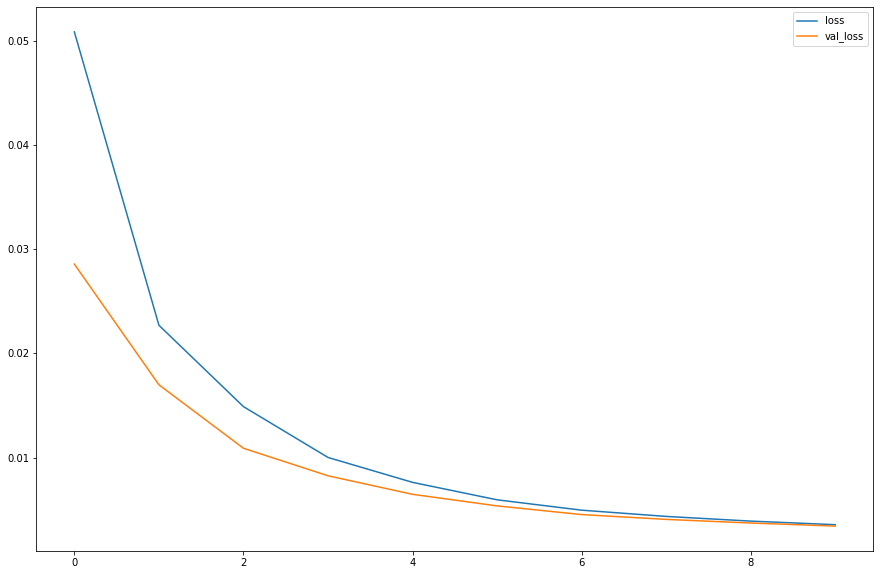

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

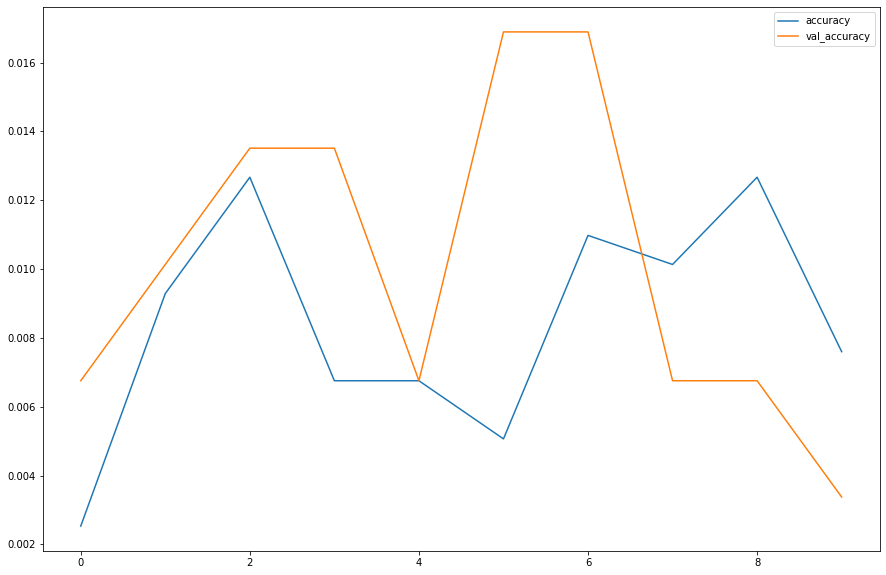

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='best')
plt.show()

**Predicting** **Results**

In [ ]:
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])


Xt = model.predict(X_test)
Xt.shape

(8, 1782)

**Un-scaling the data and returning data to original shape**

In [ ]:
#Aux function 1
def do_inverse_transform(output_result,num_companies):
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scl.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [ ]:
#Aux function 2
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

In [ ]:
#Aux function 3
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)
predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

(81, 8, 22)

In [ ]:
Yt = do_inverse_transform(y_test, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(81, 176)

**Prediction Results on Test Data - Plot**

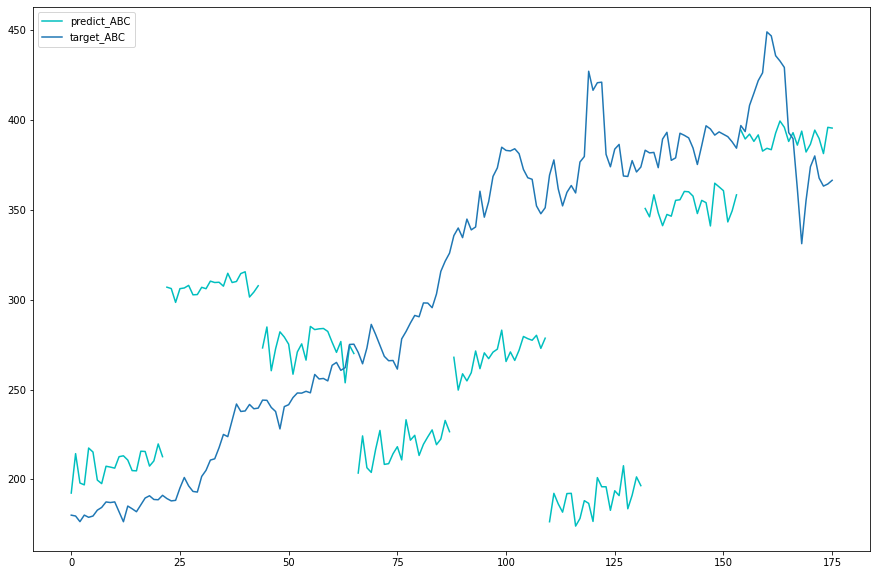

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [2] 
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'AAPL', 'ABC', 'ABMD']
 
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

In [ ]:
full_PCA = np.concatenate((PCA_train,PCA_test),axis = 0)

In [ ]:
X_all,void = processData(full_PCA,lookback,horizon,num_companies,horizon)
void,y_all = processData(scl.fit_transform(df_close),lookback,horizon,num_companies,horizon)
y_all = np.array([list(a.ravel()) for a in y_all])

In [ ]:
Xt = model.predict(X_all)
Xt.shape

(88, 1782)

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)

predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

(81, 88, 22)

In [ ]:
Yt = do_inverse_transform(y_all, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

(81, 2200)

**Prediction Results on Full Data - Plot**

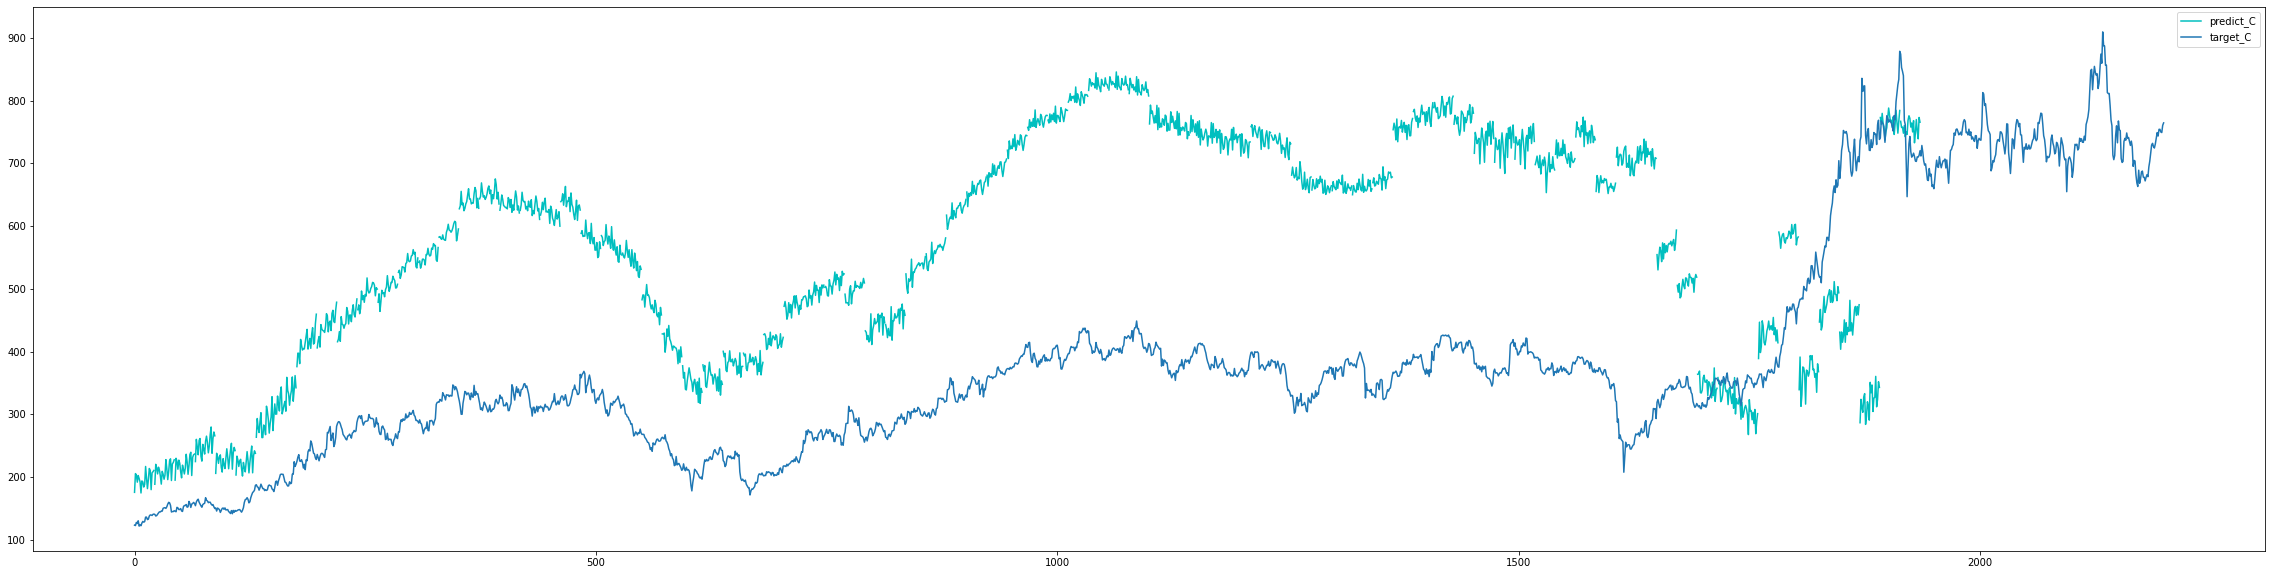

In [ ]:
plt.figure(figsize = (40,10))

companies_to_show = [2] #Type a number between 0:4 to see 4 different companies
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'B', 'C', 'D']

    
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

##QQ-plot

**Stock Prices Predictions**

In [ ]:
predicted_prices = np.zeros((predictions.shape[1]*predictions.shape[2],predictions.shape[0]))
# actual_prices = []

for i in range(predictions.shape[0]):
  counter = 0
  for j in range(predictions.shape[1]):
    for z in range(predictions.shape[2]):
      predicted_prices[counter, i] = predictions[i,j,z]
      counter+=1

print(counter)

1936


In [ ]:
actuals_prices = actuals[:,:1936].T

In [ ]:
print(predicted_prices.shape)
print(actuals_prices.shape)
print(dates.shape)
#(lookback+1, )

(1936, 81)
(1936, 81)
(2462,)


In [ ]:
(2462-lookback+1)-1936

275

In [ ]:
# Need to remove certain days because we predict into the future. But, we aren't able to test these predicted days
# against actual days in our porfolio optimization

actual_prices = pd.DataFrame(data = actuals_prices, columns = stocks,index = dates[lookback+1:2463-274])
predicted_prices = pd.DataFrame(data = predicted_prices,columns=stocks, index = dates[lookback+1:2463-274])

In [ ]:
actual_prices

Index,ACC.NS,ADANIENT.NS,ADANIPORTS.NS,AMBUJACEM.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJAJHLDNG.NS,...,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,TORNTPHARM.NS,ULTRACEMCO.NS,UPL.NS,VEDL.NS,WIPRO.NS,ZYDUSLIFE.NS
Date,,,,,,,,,,,,,,,,,,,,,
2013-08-28,942.799988,22.692371,123.500000,159.500000,883.349976,410.000000,175.529999,1727.750000,576.650024,799.700012,...,25.943018,919.400024,340.725006,221.699997,201.449997,1550.699951,94.933327,168.350006,170.606293,131.240005
2013-08-29,944.700012,22.439468,122.800003,160.100006,858.650024,392.000000,167.589996,1727.750000,588.750000,787.099976,...,26.581352,953.950012,342.562500,212.350006,199.100006,1463.699951,94.900002,169.149994,176.793793,130.369995
2013-08-30,958.049988,23.113878,127.750000,164.449997,863.299988,403.200012,170.149994,1740.449951,595.900024,810.250000,...,26.519424,973.549988,341.387512,216.899994,200.000000,1447.949951,90.933327,192.449997,177.543793,131.019989
2013-09-02,964.099976,21.688419,125.949997,171.600006,864.549988,420.950012,166.589996,1837.000000,590.099976,804.799988,...,26.104982,1016.599976,343.750000,224.649994,203.800003,1474.849976,88.933327,188.750000,181.350052,130.809998
2013-09-03,952.000000,21.328222,130.399994,170.100006,856.099976,422.399994,172.860001,1856.099976,590.250000,802.849976,...,27.572199,1028.425049,343.762512,230.600006,204.074997,1498.400024,90.699997,188.800003,181.668793,130.149994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,1996.000000,1490.250000,703.099976,340.299988,3678.449951,3021.600098,746.450012,4204.549805,11816.450195,3617.750000,...,116.355003,3341.500000,1085.150024,1740.300049,1462.099976,6707.250000,791.500000,262.899994,539.349976,639.200012
2021-07-05,1987.250000,1422.050049,710.400024,339.250000,3733.199951,3005.000000,750.650024,4175.350098,11750.450195,3677.000000,...,113.599998,3325.449951,1089.400024,1754.750000,1475.175049,6719.899902,799.349976,262.049988,538.599976,639.349976
2021-07-06,1982.750000,1394.349976,710.049988,340.299988,3718.100098,3014.800049,760.349976,4201.500000,11923.099609,3750.750000,...,115.684998,3321.000000,1074.650024,1749.900024,1469.425049,6719.850098,807.599976,272.450012,536.349976,643.950012


In [ ]:
actual_prices.to_csv('y_dataset.csv')

In [ ]:
write.csv(actual_prices, 'y_dataset.csv', row.names = FALSE)

SyntaxError: ignored

In [ ]:
predicted_prices

Index,ACC.NS,ADANIENT.NS,ADANIPORTS.NS,AMBUJACEM.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJAJHLDNG.NS,...,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,TORNTPHARM.NS,ULTRACEMCO.NS,UPL.NS,VEDL.NS,WIPRO.NS,ZYDUSLIFE.NS
Date,,,,,,,,,,,,,,,,,,,,,
2013-08-28,1168.125122,209.581070,175.747040,185.140915,2067.877441,537.469299,219.744843,2075.252197,686.764343,975.657227,...,46.432476,1317.770386,643.795227,259.062469,289.266510,1926.259766,105.283455,204.429138,351.913483,154.291000
2013-08-29,1175.395630,224.744308,205.586090,198.565857,2039.834961,524.020203,201.000854,2052.678711,673.573608,999.273315,...,46.113880,1392.945923,628.795532,273.228668,262.963165,1997.330688,115.039162,210.431747,354.935699,159.598343
2013-08-30,1140.923096,195.316467,203.242599,185.812592,2145.557617,533.543335,211.596786,2005.678345,656.498901,1006.159180,...,49.312710,1433.477905,649.845459,240.078918,302.842133,2041.852295,111.624405,207.678650,336.121124,153.781937
2013-09-02,1181.454346,203.409683,191.983185,183.757202,2139.608398,592.816040,212.488510,2004.932251,707.256897,1029.058960,...,44.516720,1344.568359,685.222351,254.153702,276.111816,1977.654663,110.424736,208.623199,349.751465,156.916840
2013-09-03,1192.129883,237.603455,202.512848,188.241058,2121.836182,600.856079,213.546753,2141.566406,694.083801,990.226257,...,49.546108,1463.139160,673.501770,241.339355,270.000885,2023.073242,111.343498,199.976059,347.657288,161.402191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,2078.775146,2215.869141,769.798157,299.970551,3966.531494,2674.658936,700.500122,3491.274414,14888.556641,5123.076172,...,106.518883,3563.668945,1561.046143,2032.026978,1353.126953,6823.322754,676.778931,255.888763,573.370239,389.155762
2021-07-05,2098.907227,2185.454834,751.567139,298.743347,4131.488770,2515.637939,721.402039,3438.084961,14816.315430,5012.432617,...,98.701790,3521.311768,1574.577759,2091.114014,1410.262329,7074.271484,646.670532,253.453568,571.571228,385.373138
2021-07-06,2051.858643,2257.159668,739.074951,305.737000,3964.316650,2591.021240,715.036804,3408.195312,15507.294922,4899.542480,...,104.207703,3563.727295,1538.662598,2054.698486,1393.890503,6988.169922,684.049072,246.847198,596.337463,387.896576


In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
predicted_prices.to_csv('PCA_Predicted_Prices1.csv')
!cp PCA_Predicted_Prices1.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

In [ ]:
actual_prices.to_csv('PCA_Actual_Prices1.csv')
!cp PCA_Actual_Prices1.csv "drive/My Drive/Machine Learning Project/ML Section Exports"